In [24]:
%matplotlib inline
# %matplotlib notebook

from __future__ import print_function

try:
    from importlib import reload
except:
    pass

import os
import sys
import warnings

import numpy as np
import pandas as pd
import astropy as ap
import sfdmap

import sqlite3
from sqlalchemy import create_engine

from matplotlib import pyplot as plt
import matplotlib.colors as mpl_colors 

import astropy.units as u

In [26]:
import pyCoCo as pccsims
import pycoco as pcc

reload(pcc)
reload(pcc.defaults)
reload(pcc.kcorr)
reload(pcc.classes)
reload(pccsims)

<module 'pyCoCo' from '/Users/berto/Code/CoCo/pyCoCo.cpython-36m-darwin.so'>

In [27]:
# %%timeit ## 1 loop, best of 3: 1min 31s per loop 
opsimdbpath = os.environ.get('OPSIMDBPATH')
print(opsimdbpath)
# opsimdbpath = "/Users/berto/data/LSST/OpSimOutputDBs/astro_lsst_01_1068_sqlite.db"
# opsimdbpath = "/Users/berto/data/LSST/OpSimOutputDBs/minion_1016_sqlite.db"

conn = create_engine('sqlite:///'+opsimdbpath, echo = False)
opsimdf = pd.read_sql_table('Summary', con=conn)

/Users/berto/data/LSST/OpSimOutputDBs/minion_1016_sqlite.db


opsimdf.columns

Load in the Atmosphere

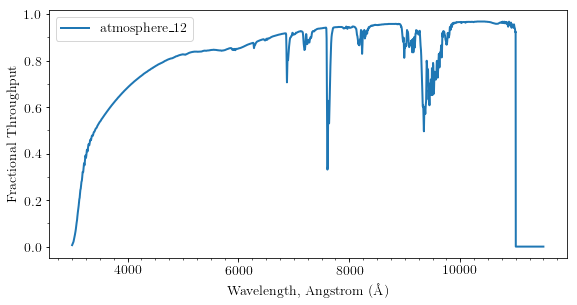

In [28]:
# atmos = pcc.kcorr.load_atmosphere()
path = os.path.join(pcc._default_lsst_throughputs_path, "baseline/atmos_std.dat")
atmos = pcc.BaseFilterClass()
atmos.load(path, wavelength_u = u.nm, fmt = "ascii.commented_header", name = "atmosphere_12")
atmos.plot()

In [67]:
lsst_filters = ["LSST_u", "LSST_g", "LSST_r", "LSST_i", "LSST_z", "LSST_y"]
# lsst_filters = ["filter_u", "filter_g", "filter_r", "filter_i", "filter_z", "filter_y"]
lsst_filters = ["hardware_u", "hardware_g", "hardware_r", "hardware_i", "hardware_z", "hardware_y"]


fdict = {}

for filter_name in lsst_filters:
    filter_path = os.path.join(pcc._default_filter_dir_path, filter_name + ".dat")
    filter_path = os.path.join("/Users/berto/projects/LSST/throughputs/baseline/", filter_name + ".dat")
#     fdict[filter_name] = pcc.load_filter(filter_path)    
    fdict[filter_name] = pcc.FilterClass()
    fdict[filter_name].load(filter_path, wavelength_u = u.nm)
#     pcc.load_filter(filter_path)    
    

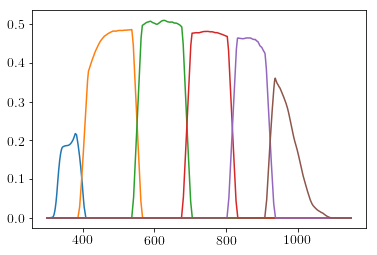

In [68]:
fig = plt.figure()

ax1 = fig.add_subplot(111)

for filter_name in lsst_filters:
    plt.plot(fdict[filter_name].data["wavelength"], fdict[filter_name].data["throughput"])
plt.show()



In [69]:
hg = fdict['hardware_g']

In [71]:
# atmos.wavelength
hg.wavelength.to(u.angstrom)

<Quantity [  3000.,  3001.,  3002.,...,  11498., 11499., 11500.] Angstrom>

filter_name:  hardware_u
filter_name:  hardware_g
filter_name:  hardware_r
filter_name:  hardware_i
filter_name:  hardware_z
filter_name:  hardware_y


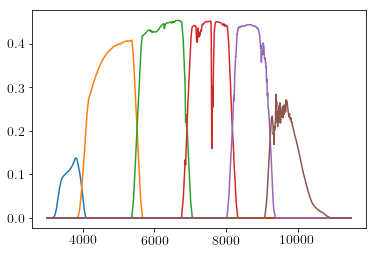

In [72]:
fig = plt.figure()

ax1 = fig.add_subplot(111)

for filter_name in lsst_filters:
    print("filter_name: ", filter_name )
    fdict[filter_name].resample_response(new_wavelength = atmos.wavelength)
    plt.plot(fdict[filter_name].wavelength, fdict[filter_name].throughput*atmos.throughput)
plt.show()

Load in the sky spectrum

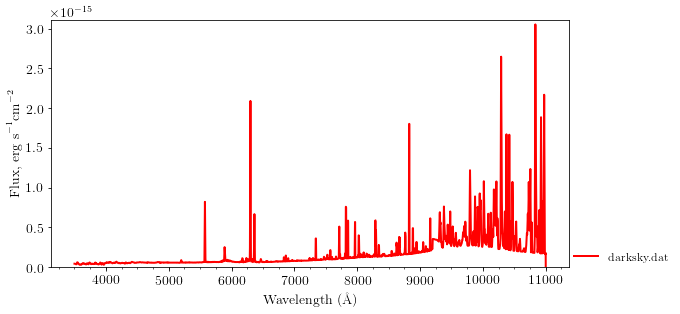

In [73]:
dark_sky_path = os.path.join(os.environ["LSST_THROUGHPUTS_BASELINE"],"darksky.dat")
darksky = pcc.SpectrumClass()
darksky.load(dark_sky_path, wavelength_u = u.nm, fmt = "ascii.commented_header", wmin = 3500*u.angstrom, wmax = 11000*u.angstrom,)
darksky.plot()

Which is equivalent to:

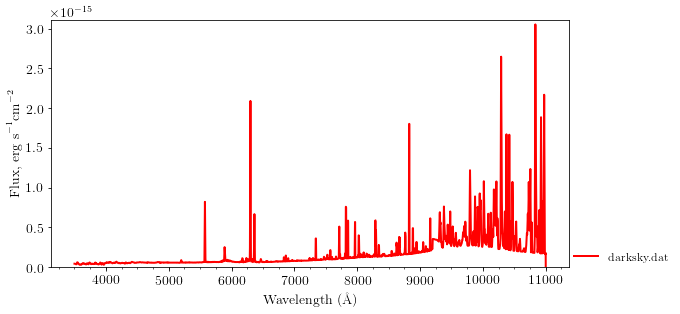

In [74]:
darksky = pcc.kcorr.load_dark_sky_spectrum()
darksky.plot()

In [75]:
lsst_filters = ["LSST_u", "LSST_g", "LSST_r", "LSST_i", "LSST_z", "LSST_y"]

for filter_name in lsst_filters:
    zp = pcc.kcorr.calc_AB_zp(filter_name)
    print(filter_name, " F_sky = ", pcc.kcorr.calc_spectrum_filter_flux(filter_name, darksky))
    print(filter_name, "m_sky = ", -2.5 * np.log10(pcc.kcorr.calc_spectrum_filter_flux(filter_name, darksky)) - zp)    

/Users/berto/Code/verbose-enigma/pycoco/utils.py:164: UserWarning: /Users/berto/Code/CoCo/data/filtersLSST_u.dat is not a valid file. Returning 'False'.
  " is not a valid file. Returning 'False'.")
/Users/berto/Code/verbose-enigma/pycoco/functions.py:72: UserWarning: Couldn't load the filter
  warnings.warn("Couldn't load the filter")


AttributeError: 'NoneType' object has no attribute 'throughput'

Create a df that just looks at the first observation in each filter

In [ ]:
opsimdf_f = opsimdf.drop_duplicates("filter")

opsimdf_f

In [ ]:
opsimdf_f[["filter", "filtSkyBrightness", "darkBright"]]

# OpSim m5 derivation 

Recreating the m5 values, as per http://smtn-002.lsst.io/en/latest/

\begin{split}m5 = C_m + dC_m + 0.50\,(m_{sky} - 21.0) + 2.5 log_{10}(0.7 /
FWHM_{eff}) \\
+ 1.25 log_{10}(expTime / 30.0) - k_{atm}\,(X-1.0)\end{split}

\begin{split}dC_m = dC_m^{inf} - 1.25 log_{10}(1 + (10^{(0.8\, dC_m^{inf} -
1)}/Tscale)\end{split}

\begin{split}Tscale = expTime / 30.0 * 10.0^{-0.4*(m_{sky} - m_{darksky})}\end{split}


In [ ]:
def calc_Tscale(df):
    Tscale = df["visitExpTime"].head()/30. * np.power(10., -0.4*())
    return Tscale


def calc_dCm():
    dCm = False
    return dCm


def calc_m5():
    m5 = False
    return m5

